In [1]:
# 문장을 인덱스 리스트로 변환 (encode)
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 인덱스 리스트를 문장으로 변환 (decode)
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 데이터 준비

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
train_data = pd.read_table('~/aiffel/ws/project/exploration_6/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/ws/project/exploration_6/data/ratings_test.txt')

train_data.head()
print(train_data.shape)

(150000, 3)


# 데이터 전처리

## 토큰화, indexing, 단어 사전 생성

1. NaN 결측치 제거
1. 데이터의 중복 제거
1. 한국어 토크나이저로 토큰화
1. 불용어(Stopwords) 제거
1. 사전word_to_index 구성
1. 텍스트 스트링을 사전 인덱스 스트링으로 변환
1. X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
def tokenization(data_):
    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    
    # 결측치 제거
    data_.dropna(how='any', axis=0, inplace=True) 
    # 데이터 중복 제거
    data_.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)

    X_data = []
    for sentence in data_['document']:
        # 토큰화
        temp_X = tokenizer.morphs(sentence) 
        # 불용어 제거
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_data.append(temp_X)
    return X_data

    
def make_dic_word(X_data):
    words = np.concatenate(X_data).tolist()
    # print(len(words))
    counter = Counter(words)
    counter = counter.most_common(len(counter))
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    map_word_to_index = {word:index for index, word in enumerate(vocab)}
    return map_word_to_index
    
    
def make_word_to_index(X_data, map_word_to_index):
    def convert_word_to_index(word:list):
        return [map_word_to_index[ele_word] if ele_word in map_word_to_index else map_word_to_index['<PAD>'] for ele_word in word]
    return list(map(convert_word_to_index, X_data))

    
def preprocess_data(data_train, data_test):
    X_train = tokenization(data_train)
    X_test = tokenization(data_test)
    
    map_word_to_index = make_dic_word(X_train)
    
    X_train_indexed = make_word_to_index(X_train, map_word_to_index)
    X_test_indexed = make_word_to_index(X_test, map_word_to_index)
    
    y_train = np.array(list(data_train['label']))
    y_test = np.array(list(data_test['label']))
    return X_train_indexed, y_train, X_test_indexed, y_test, map_word_to_index 


X_train, y_train, X_test, y_test, word_to_index = preprocess_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(X_train))

146182


## 데이터 분석 및 가공

1. 데이터셋 내 문장 길이 분포
1. 적절한 최대 문장 길이 지정
1. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
# 적절한 문장 길이 구함 (평균 + 2*표준편차)
data_total = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in data_total]
num_tokens = np.array(num_tokens)

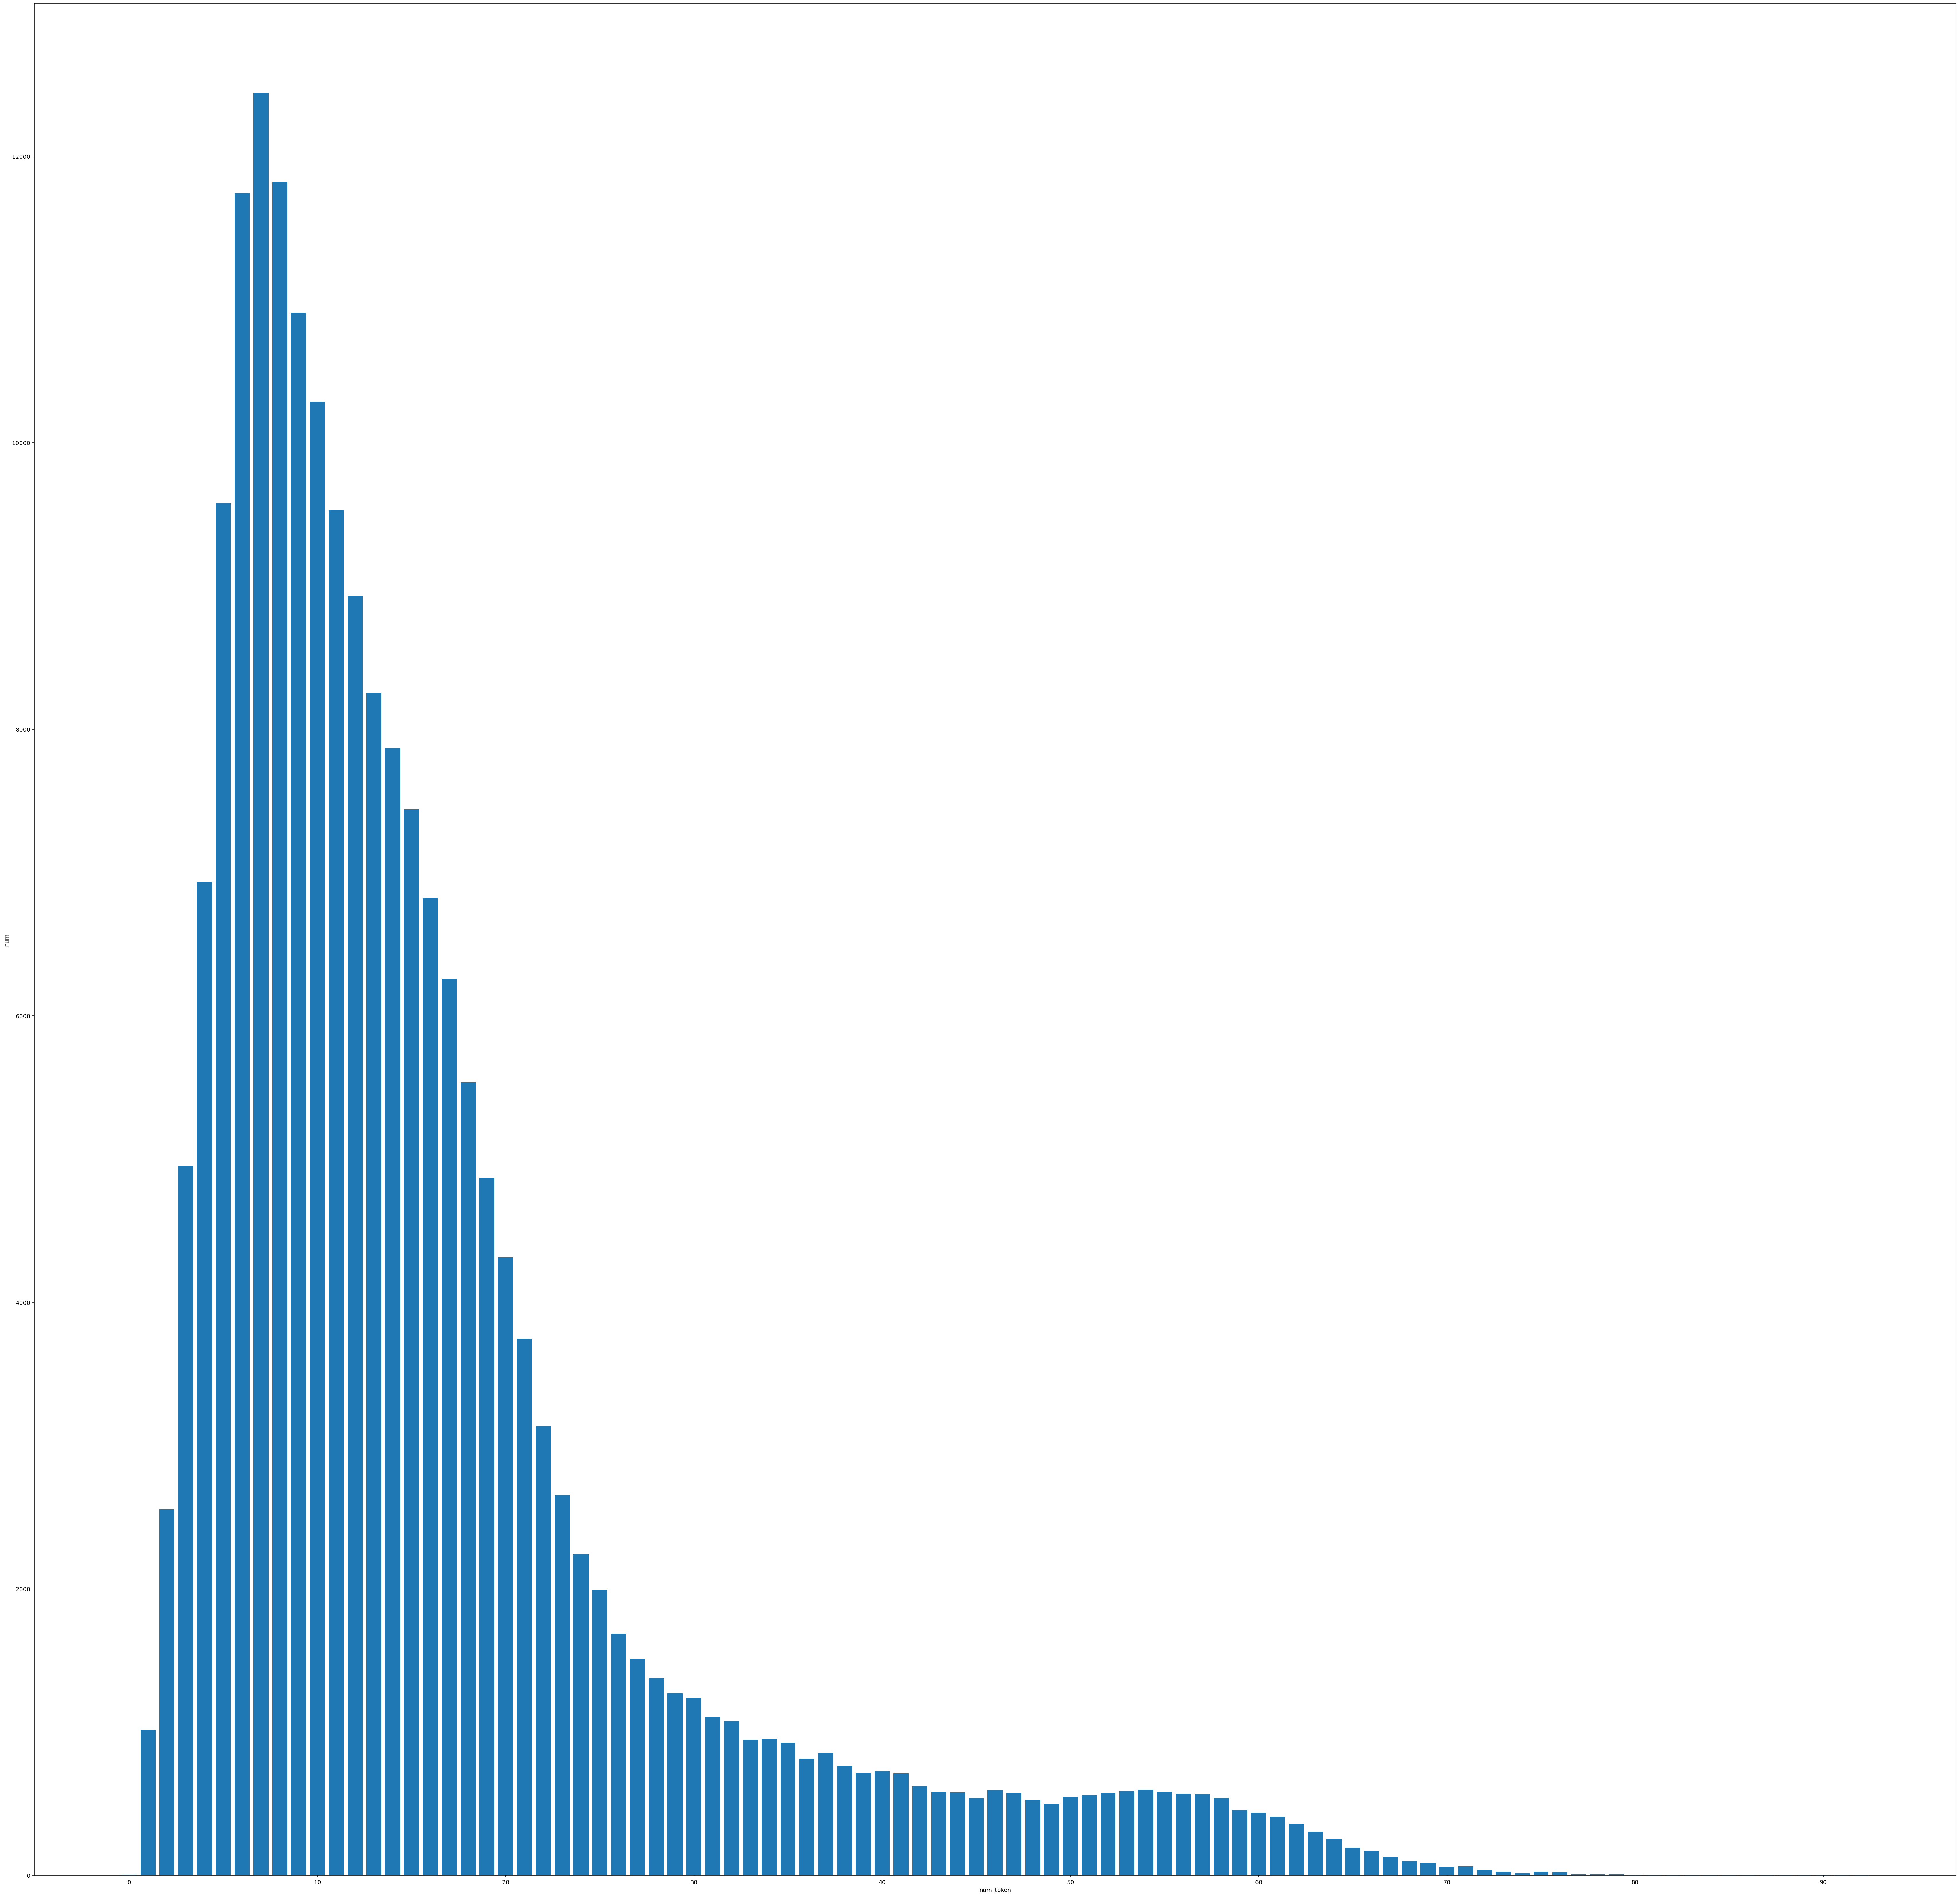

In [6]:
# 데이터셋 길이 분포
counter = Counter(num_tokens)
key = list(counter.keys())
key.sort()
val = [counter[k] for k in key]

idx_cnt = np.arange(len(key))
plt.figure(figsize=(60,60))
plt.xlabel('num_token')
plt.ylabel('num')
plt.rc('axes', labelsize=100)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=100)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=100)  # y축 눈금 폰트 크기
plt.xticks(range(0, len(key), 10))

plt.bar(idx_cnt, val)
plt.show()

In [7]:
# 데이터 길이 선정
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
maxlen_manual = 65
print(maxlen)

41


In [8]:
# 패딩
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

# validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [9]:
num_vali = int(len(X_train_pad)/4)

# validation set
x_val = X_train_pad[:num_vali]
y_val = y_train[:num_vali]

# train set
partial_x_train = X_train_pad[num_vali:]  
partial_y_train = y_train[num_vali:]

print(x_val.shape)
print(partial_x_train.shape)

(36545, 41)
(109637, 41)


# 모델 학습, 평가


In [10]:
# 어휘 사전의 크기입니다(
vocab_size = len(word_to_index)  
# 워드 벡터의 차원 수
word_vector_dim = 16
print(vocab_size)

BATCH_SIZE = 8192
EPOCH_RNN = 10
EPOCH_CNN = 10
EPOCH_GMP = 10
history = []
results = []

log_ = [f'vector_dim : {word_vector_dim}, BATCH_SIZE : {BATCH_SIZE}, EPOCH_RNN : {EPOCH_RNN}, EPOCH_CNN : {EPOCH_CNN}, EPOCH_GMP : {EPOCH_GMP}, ']


53965


## 1-D CNN

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          863440    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=EPOCH_CNN
his = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)
history.append(his)

resul = model.evaluate(X_test_pad,  y_test, verbose=2)
print(resul)
results.append(resul)


Epoch 1/10
14/14 [==============================] - 4s 72ms/step - loss: 0.6927 - accuracy: 0.5138 - val_loss: 0.6915 - val_accuracy: 0.5479
Epoch 2/10
14/14 [==============================] - 0s 19ms/step - loss: 0.6887 - accuracy: 0.6031 - val_loss: 0.6835 - val_accuracy: 0.6205
Epoch 3/10
14/14 [==============================] - 0s 20ms/step - loss: 0.6719 - accuracy: 0.6643 - val_loss: 0.6545 - val_accuracy: 0.6916
Epoch 4/10
14/14 [==============================] - 0s 20ms/step - loss: 0.6246 - accuracy: 0.7290 - val_loss: 0.5892 - val_accuracy: 0.7686
Epoch 5/10
14/14 [==============================] - 0s 19ms/step - loss: 0.5400 - accuracy: 0.7957 - val_loss: 0.5006 - val_accuracy: 0.8090
Epoch 6/10
14/14 [==============================] - 0s 19ms/step - loss: 0.4438 - accuracy: 0.8354 - val_loss: 0.4265 - val_accuracy: 0.8241
Epoch 7/10
14/14 [==============================] - 0s 19ms/step - loss: 0.3687 - accuracy: 0.8572 - val_loss: 0.3869 - val_accuracy: 0.8348
Epoch 8/10
14

## GlobalMaxPooling1D

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          863440    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 863,585
Trainable params: 863,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=EPOCH_GMP
his = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)
history.append(his)

resul = model.evaluate(X_test_pad,  y_test, verbose=2)
print(resul)
results.append(resul)


Epoch 1/10
14/14 [==============================] - 1s 17ms/step - loss: 0.6915 - accuracy: 0.4996 - val_loss: 0.6878 - val_accuracy: 0.5140
Epoch 2/10
14/14 [==============================] - 0s 9ms/step - loss: 0.6839 - accuracy: 0.5564 - val_loss: 0.6796 - val_accuracy: 0.5953
Epoch 3/10
14/14 [==============================] - 0s 9ms/step - loss: 0.6728 - accuracy: 0.6321 - val_loss: 0.6662 - val_accuracy: 0.6521
Epoch 4/10
14/14 [==============================] - 0s 9ms/step - loss: 0.6562 - accuracy: 0.6948 - val_loss: 0.6490 - val_accuracy: 0.6963
Epoch 5/10
14/14 [==============================] - 0s 8ms/step - loss: 0.6350 - accuracy: 0.7332 - val_loss: 0.6272 - val_accuracy: 0.7214
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 0.6088 - accuracy: 0.7613 - val_loss: 0.6020 - val_accuracy: 0.7448
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.5792 - accuracy: 0.7857 - val_loss: 0.5750 - val_accuracy: 0.7624
Epoch 8/10
14/14 [=

## RNN

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          863440    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 864,321
Trainable params: 864,321
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=EPOCH_RNN
his = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)
history.append(his)

resul = model.evaluate(X_test_pad,  y_test, verbose=2)
print(resul)
results.append(resul)


Epoch 1/10
14/14 [==============================] - 2s 51ms/step - loss: 0.6902 - accuracy: 0.6275 - val_loss: 0.6853 - val_accuracy: 0.6985
Epoch 2/10
14/14 [==============================] - 0s 18ms/step - loss: 0.6790 - accuracy: 0.7319 - val_loss: 0.6700 - val_accuracy: 0.7485
Epoch 3/10
14/14 [==============================] - 0s 18ms/step - loss: 0.6574 - accuracy: 0.7717 - val_loss: 0.6410 - val_accuracy: 0.7743
Epoch 4/10
14/14 [==============================] - 0s 18ms/step - loss: 0.6173 - accuracy: 0.7983 - val_loss: 0.5897 - val_accuracy: 0.7977
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 0.5523 - accuracy: 0.8200 - val_loss: 0.5177 - val_accuracy: 0.8142
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.4790 - accuracy: 0.8285 - val_loss: 0.4688 - val_accuracy: 0.8102
Epoch 7/10
14/14 [==============================] - 0s 18ms/step - loss: 0.4289 - accuracy: 0.8413 - val_loss: 0.4307 - val_accuracy: 0.8294
Epoch 8/10
14

# Loss, Accuracy 그래프 시각화

In [17]:
history_dict = history[0].history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


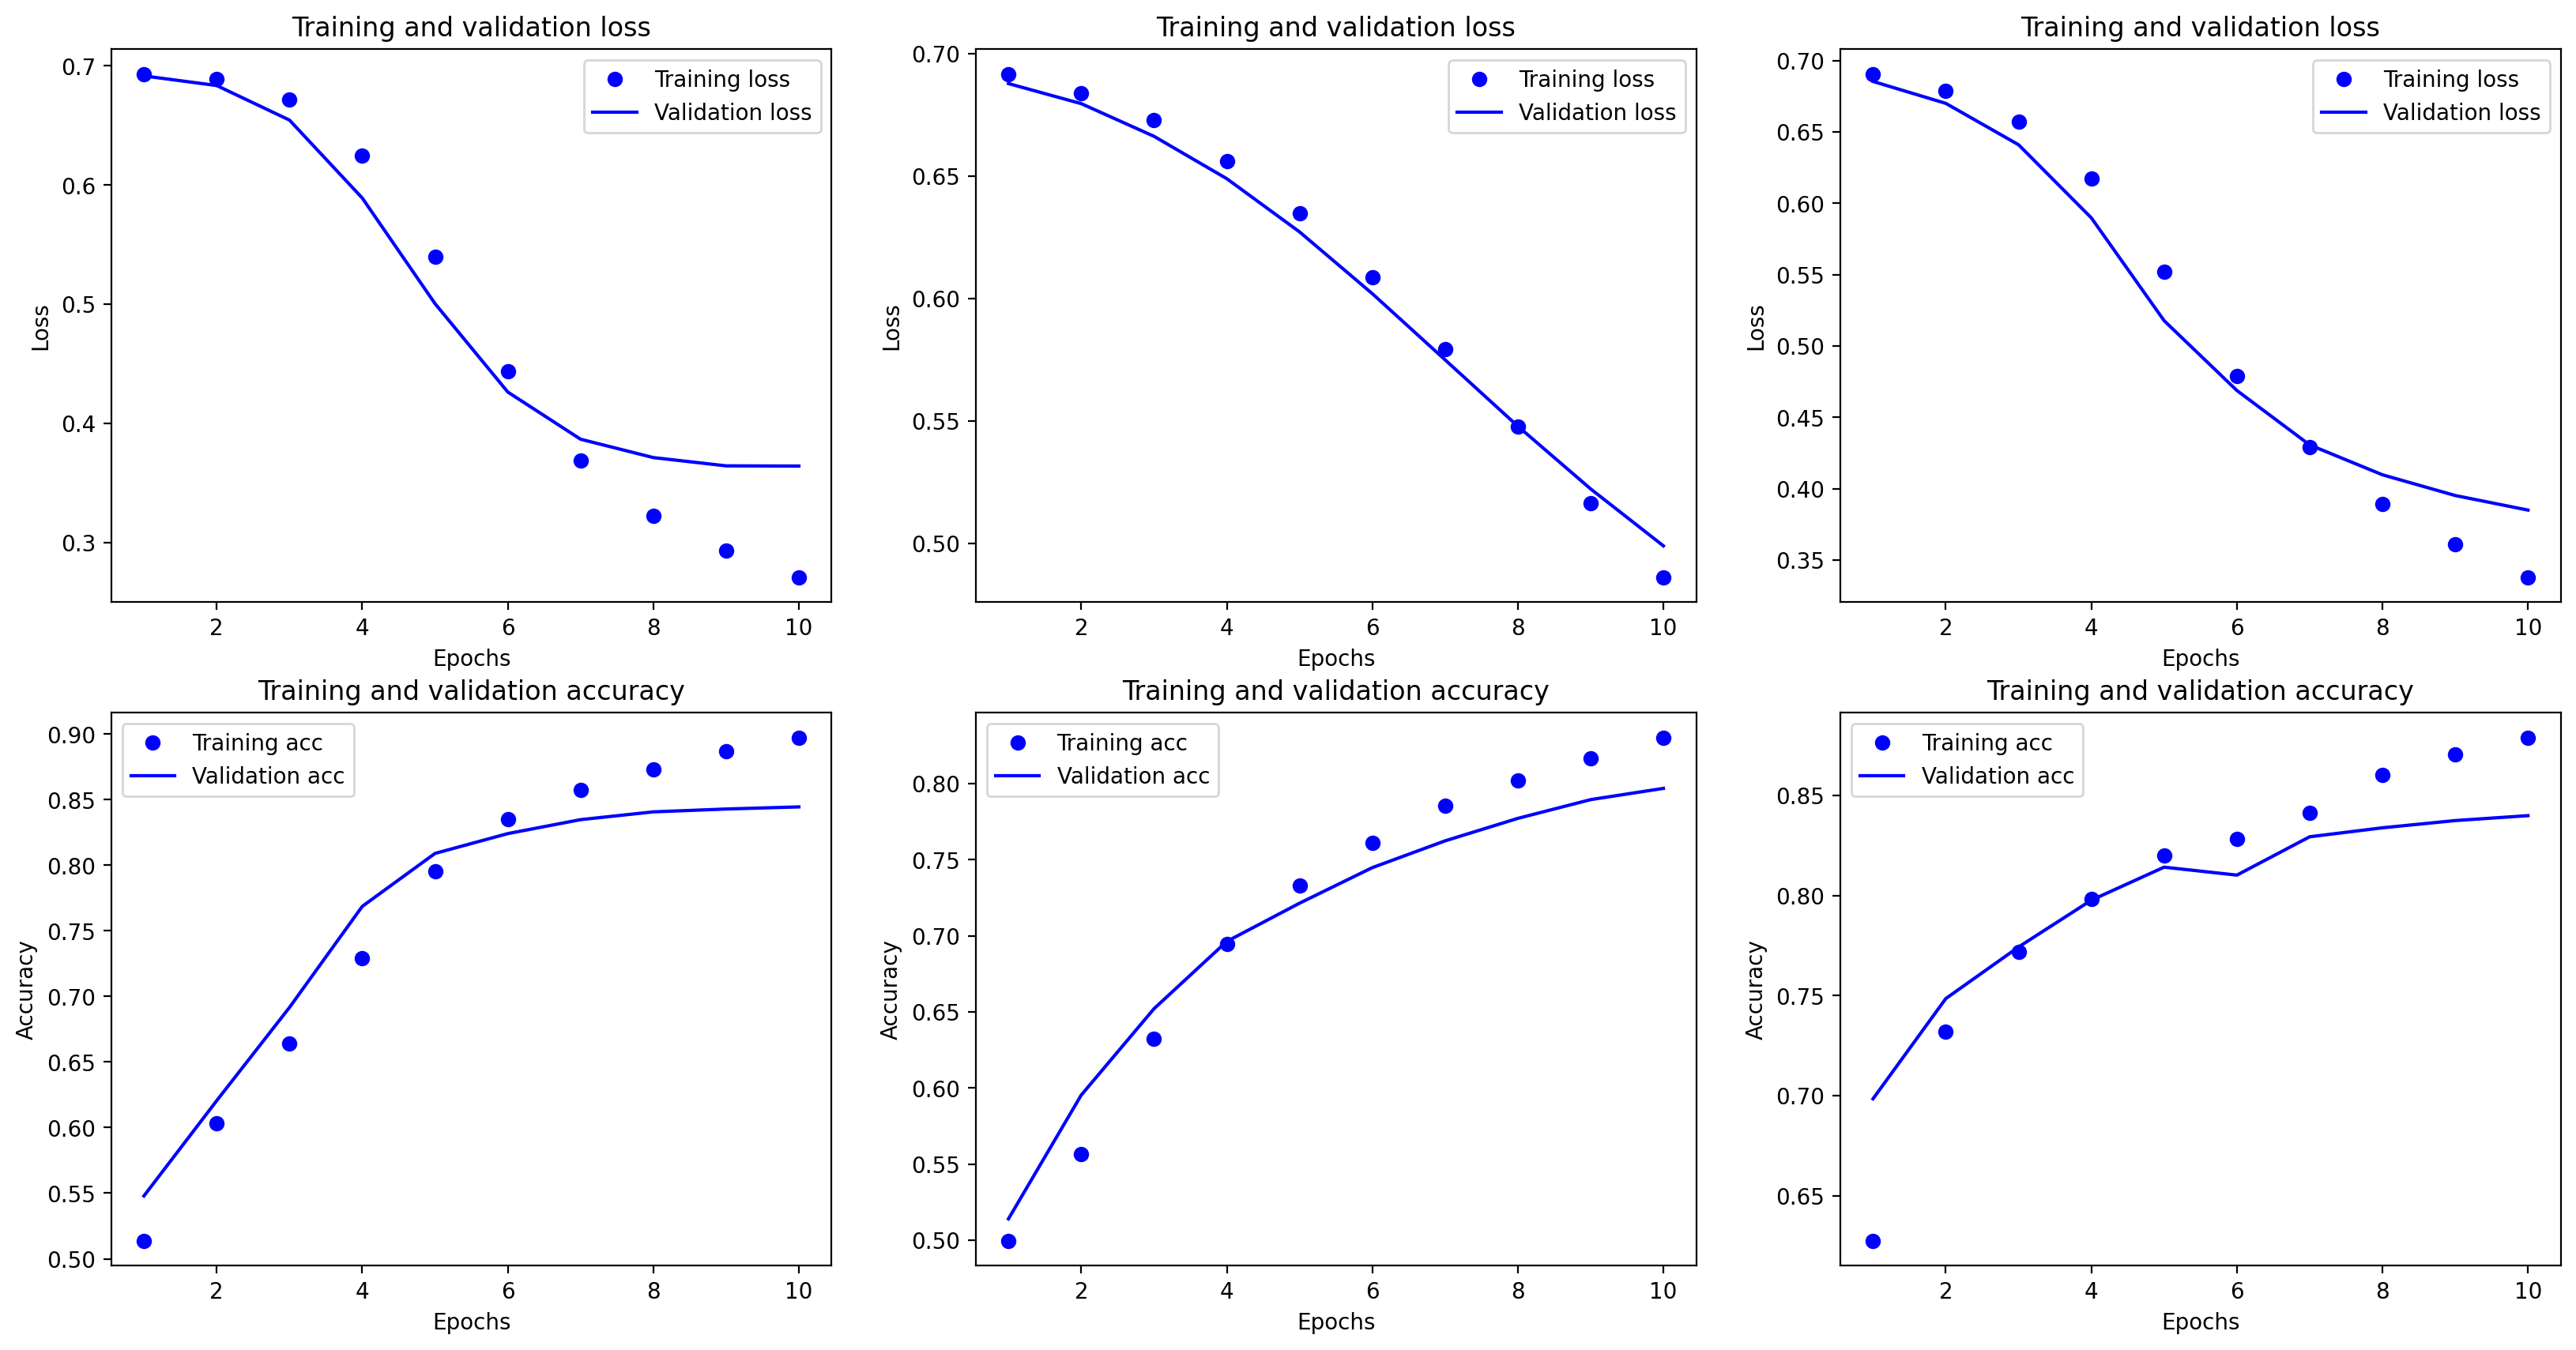

In [18]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig = plt.figure(figsize = (20,10))

idx_plot = 1
for hist in history:
    history_dict = hist.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)

    axes = fig.add_subplot(2,3,idx_plot)
    # "bo"는 "파란색 점"입니다
    axes.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    axes.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    axes = fig.add_subplot(2,3,idx_plot+3)
    axes.plot(epochs, acc, 'bo', label='Training acc')
    axes.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    idx_plot += 1

plt.show()
    

# 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 16)


In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
print(vectors[4, :])
print(index_to_word[4])
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

[ 0.0107745  -0.0722511  -0.02744459  0.08933428 -0.03448037  0.05214166
  0.11365319  0.01907585  0.0245261   0.02693121 -0.1556418   0.04459236
 -0.12192497 -0.03180404  0.03529433  0.13144869]
.


In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.0305387 , -0.04711135,  0.02340808,  0.00941853, -0.07850151,
       -0.01334018,  0.02197505, -0.06488279, -0.01563144, -0.0131896 ,
        0.0018373 , -0.0179826 ,  0.01882313, -0.0011501 , -0.01136513,
        0.0446655 ], dtype=float32)

### 'love' 단어 벡터 유사 단어

In [22]:
print(word_to_index["love"])
word_vectors.similar_by_word("love")


5306


[('.!', 0.9794270992279053),
 ('감사', 0.9747580289840698),
 ('아픔', 0.9736326336860657),
 ('올리', 0.9734522104263306),
 ('그렇지만', 0.972942054271698),
 ('천재', 0.9722395539283752),
 ('파이팅', 0.9711824655532837),
 ('틈', 0.9709186553955078),
 ('♡', 0.970585823059082),
 ('두려움', 0.9704020023345947)]

### '재밌' 단어 벡터 유사 단어

In [23]:
print(word_to_index["재밌"])
word_vectors.similar_by_word("재밌")


34


[('미남', 0.9794377088546753),
 ('핫세', 0.9789326190948486),
 ('찬사', 0.9779703617095947),
 ('압도', 0.9759832620620728),
 ('안다', 0.9741154909133911),
 ('예뻐요', 0.9738082885742188),
 ('이제야', 0.9737411737442017),
 ('손색없', 0.9735163450241089),
 ('굿', 0.9732517600059509),
 ('낮', 0.9725103378295898)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [24]:
import os
from gensim.models import KeyedVectors
import gensim
import numpy as np
from tensorflow.keras.initializers import Constant

from konlpy.tag import Mecab
from collections import Counter
import pandas as pd
import tensorflow as tf

In [25]:
vocab_size = 30000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수

word2vec_path = './data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_6054/1593578888.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6054/1593578888.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [26]:

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(200))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 6,334,721
Trainable params: 6,334,721
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=16384,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
7/7 [==============================] - 6s 690ms/step - loss: 0.6483 - accuracy: 0.6183 - val_loss: 0.5886 - val_accuracy: 0.6883
Epoch 2/20
7/7 [==============================] - 4s 635ms/step - loss: 0.5824 - accuracy: 0.6931 - val_loss: 0.5593 - val_accuracy: 0.7098
Epoch 3/20
7/7 [==============================] - 4s 640ms/step - loss: 0.5434 - accuracy: 0.7234 - val_loss: 0.5237 - val_accuracy: 0.7366
Epoch 4/20
7/7 [==============================] - 5s 650ms/step - loss: 0.5080 - accuracy: 0.7502 - val_loss: 0.4980 - val_accuracy: 0.7597
Epoch 5/20
7/7 [==============================] - 5s 653ms/step - loss: 0.4793 - accuracy: 0.7708 - val_loss: 0.4695 - val_accuracy: 0.7780
Epoch 6/20
7/7 [==============================] - 5s 656ms/step - loss: 0.4508 - accuracy: 0.7909 - val_loss: 0.4471 - val_accuracy: 0.7908
Epoch 7/20
7/7 [==============================] - 5s 653ms/step - loss: 0.4270 - accuracy: 0.8049 - val_loss: 0.4310 - val_accuracy: 0.8004
Epoch 8/20
7/7 [====

In [28]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3606 - accuracy: 0.8457
[0.36060231924057007, 0.8457188010215759]


### loss : 0.36060231924057007
### accuracy : 0.8457188010215759


# Loss, Accuracy 그래프 시각화

In [30]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


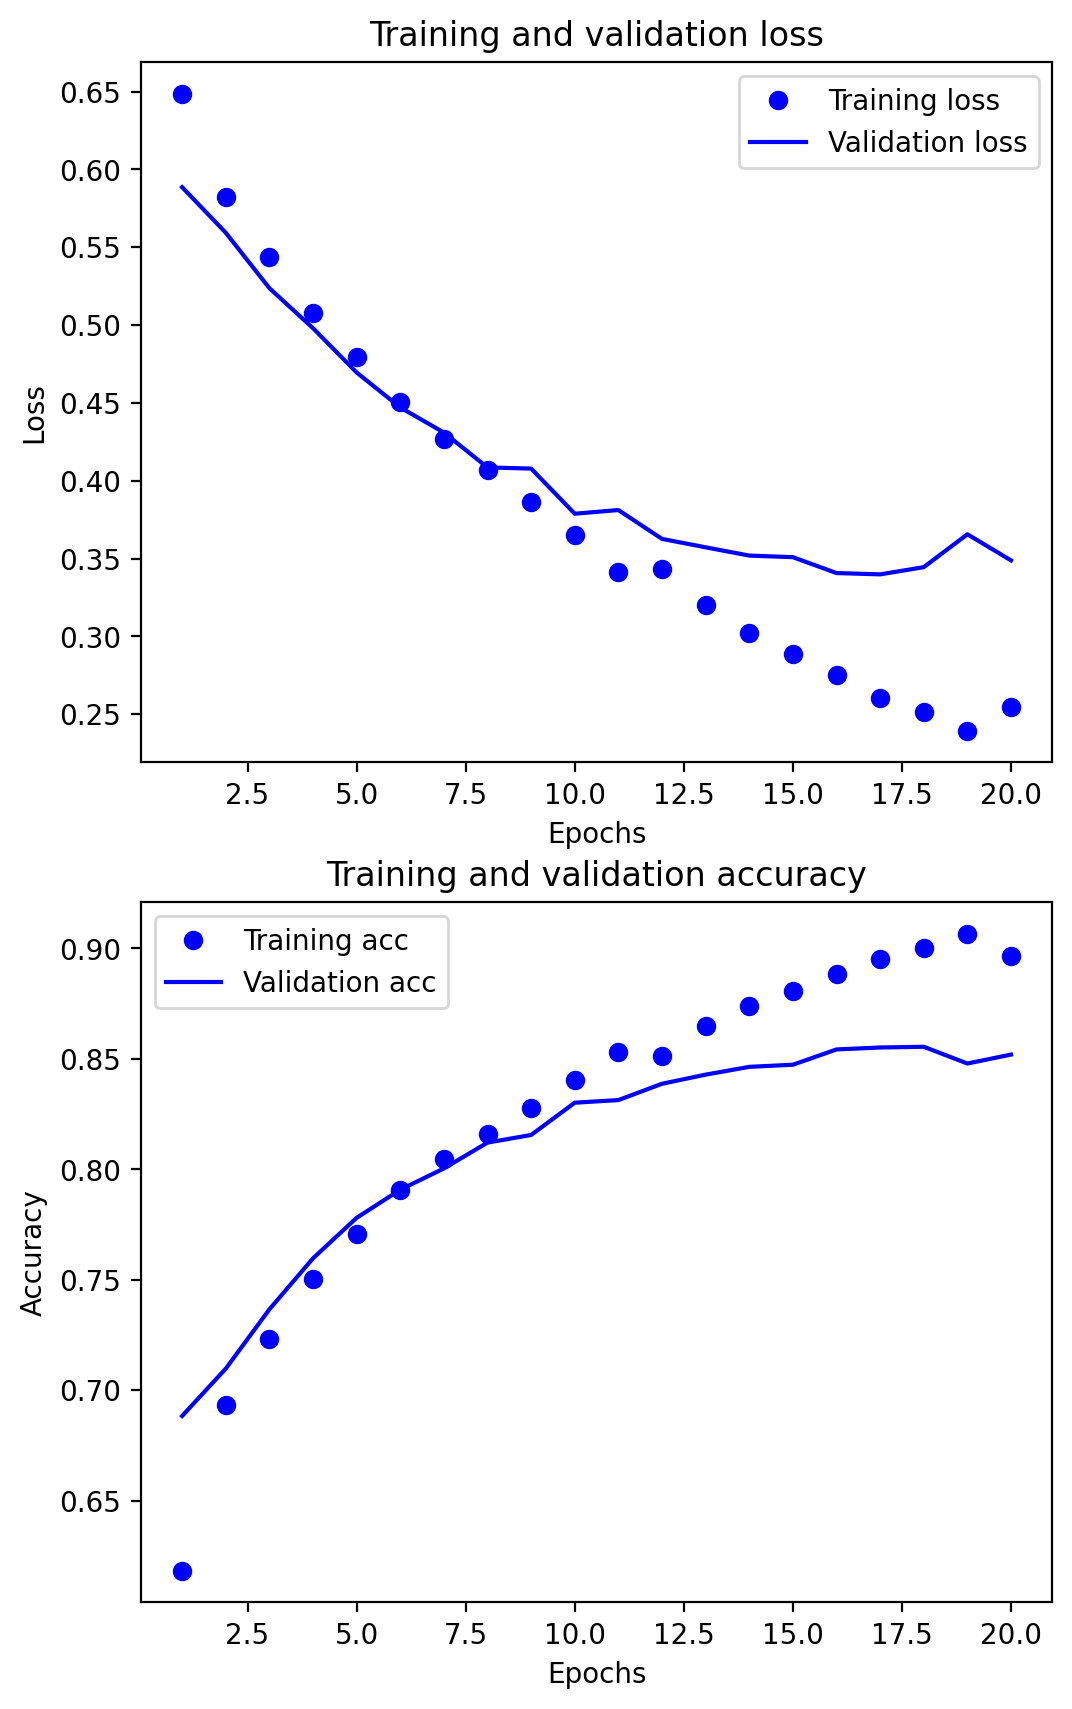

In [31]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig = plt.figure(figsize = (20,10))

idx_plot = 1
history = [history]
for hist in history:
    history_dict = hist.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)

    axes = fig.add_subplot(2,3,idx_plot)
    # "bo"는 "파란색 점"입니다
    axes.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    axes.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    axes = fig.add_subplot(2,3,idx_plot+3)
    axes.plot(epochs, acc, 'bo', label='Training acc')
    axes.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    idx_plot += 1

plt.show()
    

# 학습된 Embedding 레이어 분석

In [32]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 200)


In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
print(vectors[4, :])
print(index_to_word[4])
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

[ 7.44617343e-01  2.34872013e-01  1.17145145e+00 -7.13036731e-02
 -8.58945370e-01 -4.64645654e-01  6.19756997e-01 -1.19210267e+00
  1.29992867e+00  2.01256782e-01 -1.35921776e+00 -5.42314827e-01
 -4.19104874e-01  5.98921716e-01  8.34462225e-01 -3.29866767e-01
  9.48142946e-01  2.17576766e+00  5.99060059e-01  4.38564271e-01
  8.90452981e-01 -6.75677955e-01 -8.29914093e-01 -1.08678564e-01
 -4.57942724e-01 -1.29062283e+00 -1.18179359e-01 -1.60186779e+00
  1.12952948e+00  9.53999758e-01  3.21339130e-01  2.08382559e+00
 -6.78725243e-01  1.10646892e+00  1.35453388e-01 -4.29250926e-01
 -4.43848550e-01  4.62854534e-01 -2.99236625e-01  5.43619208e-02
 -9.89440858e-01 -5.32223105e-01  2.09764600e-01  3.24867874e-01
  1.77313232e+00  5.56656241e-01 -3.50645274e-01  1.83816421e+00
 -5.20602405e-01 -1.17944218e-01  1.02432810e-01  4.71202135e-01
  1.10986960e+00 -6.15544140e-01 -1.19175744e+00 -1.01734793e+00
 -4.58974034e-01  8.00180901e-03 -6.49792254e-01 -1.15371883e+00
 -1.35300589e+00  1.18175

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-1.3485478 , -1.7722552 ,  3.36964   , -2.6371212 , -1.4351544 ,
        1.4147396 ,  0.91813   ,  1.9492642 ,  0.16496454,  0.5159296 ,
       -0.82143015,  2.0540833 ,  0.8375877 ,  0.8487163 , -0.08694854,
        0.26098973, -1.2538842 , -0.01928441,  1.4594939 , -0.1873914 ,
       -0.30904543, -0.97237986,  1.055181  ,  0.31603804,  2.6703951 ,
       -1.0728323 ,  0.3559404 , -0.70882916, -2.5525186 , -0.6311076 ,
        2.852836  ,  0.46335053, -0.9774269 , -1.4795282 ,  1.0750055 ,
        0.5635138 , -0.57034814, -0.62571913,  1.3815463 ,  2.3260458 ,
       -1.4616926 ,  0.4564031 ,  1.0968847 , -3.2019758 , -0.29121   ,
       -1.1663289 ,  1.2219352 , -0.80041564, -0.33809513,  1.1817262 ,
        0.00766451, -0.69902587,  1.5314941 ,  1.1073068 , -1.0347576 ,
       -0.61476916,  1.0944676 , -1.1172832 ,  0.14462416,  2.0197437 ,
       -0.18735215,  1.3703485 ,  0.68457067,  0.32952142,  1.0123295 ,
        0.3912969 ,  1.1753391 ,  2.839724  ,  2.422952  , -1.35

In [35]:
word_vectors.similar_by_word("재밌")

[('재미있', 0.7641834020614624),
 ('웃기', 0.71930992603302),
 ('멋지', 0.6860332489013672),
 ('슬프', 0.6573494672775269),
 ('즐겁', 0.6438385248184204),
 ('생각나', 0.6436575651168823),
 ('안타깝', 0.6189043521881104),
 ('맛있', 0.6084554195404053),
 ('신나', 0.5875985622406006),
 ('애절', 0.5863796472549438)]